In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

read data

In [21]:
state_census_df = pd.read_csv("../output/state_census.csv", dtype={'state_fips': str}).set_index('state_fips')
demo_df = pd.read_csv("../output/comscore_demo.csv", index_col=0, dtype={'state_fips': str})
us_census_df = pd.read_csv("../output/us_census.csv", index_col=0)
state_census_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate,state_abbr
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,217004.0,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0,7169967.0,WA
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,165617.0,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0,5436519.0,CO
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,247138.0,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0,8960161.0,NJ
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,446453.0,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0,12854526.0,IL
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,1105197.0,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0,38982847.0,CA


In [19]:
census_mapping = pd.DataFrame([
    # education level. 
    # Note discrepancy: ACS is for individuals > 25 yrs
    # vs ComScore data for household
    ['DP02_0064E', 4, 'bachelors degree', 'hoh_most_education'],
    ['DP02_0061E', 1, 'high school graduate', 'hoh_most_education'],
    ['DP02_0065E', 5, 'graduate degree', 'hoh_most_education'],
    ['DP02_0062E', 2, 'some college, no degree', 'hoh_most_education'],
    ['DP02_0063E', 3, 'associates degree', 'hoh_most_education'],
    # two rows for comscore-coded zero. Should sum for comparison.
    ['DP02_0060E', 0, '9-12 grade no diploma', 'hoh_most_education'],
    ['DP02_0059E', 0, 'less than 9th grade', 'hoh_most_education'],
    # Racial Background
    # ComScore uses 1,2,3,5
    # TODO / Question: is non-hispanic encoding right one to use?
    # e.g. instead use DP05_0037PE
    ['DP05_0077E', 1, 'non-hispanic white', 'racial_background'], 
    ['DP05_0078E', 2, 'non-hispanic black', 'racial_background'],
    ['DP05_0080E', 3, 'non-hispanic asian', 'racial_background'],
    # ComScore 5: other
    
    # Country of origin: hispanic / non-hispanic
    ['DP05_0071E', 1, 'hispanic', 'country_of_origin'],
    
    # Household income
    # ComScore: 1 Less than 15k 2 15k-24.999k 3 25k-34.999k 
    # 4 35k-49.999k 5 50k-74.999k 6 75k-99.999k 7 100k+
    # two rows for ComScore-coded 1
    ['DP03_0052E', 1, 'Less than $10,000', 'household_income'],
    ['DP03_0053E', 1, '\$10,000 to $14,999', 'household_income'],
    ['DP03_0054E', 2, '\$15,000 to $24,999', 'household_income'],
    ['DP03_0055E', 3, '\$25,000 to $34,999', 'household_income'],
    ['DP03_0056E', 4, '\$35,000 to $49,999', 'household_income'],
    ['DP03_0057E', 5, '\$50,000 to $74,999', 'household_income'],
    ['DP03_0058E', 6, '\$75,000 to $99,999', 'household_income'],
    ['DP03_0059E', 7, '\$100,000 to $149,999', 'household_income'],
    ['DP03_0060E', 7, '\$150,000 to $199,999', 'household_income'],
    ['DP03_0061E', 7, '\$200,000 or more', 'household_income'],
    
], columns=['census_code', 'comscore_code', 'description', 'comscore_column'])

In [17]:
state_pop_df = (
    state_census_df[['population estimate','state_abbr']]
    .assign(comscore_count=lambda x: x.index.map(demo_df.state_fips.value_counts()))
).sort_values('population estimate', ascending=False)
state_pop_df.head()

,population estimate,state_abbr,comscore_count
state_fips,,,
06,38982847.0,CA,9285
48,27419612.0,TX,8028
12,20278447.0,FL,7110
36,19798228.0,NY,5798
17,12854526.0,IL,3670


Income

In [22]:
census_incomes = census_mapping[census_mapping.comscore_column == 'household_income'][
    ['census_code','comscore_code']
].set_index('census_code')
census_incomes['count'] = us_census_df.transpose()
census_incomes

,comscore_code,count
census_code,,
DP03_0052E,1,7942251.0
DP03_0053E,1,5768114.0
DP03_0054E,2,11637905.0
DP03_0055E,3,11330288.0
DP03_0056E,4,15412493.0
DP03_0057E,5,21000314.0
DP03_0058E,6,14636046.0
DP03_0059E,7,16701857.0
DP03_0060E,7,6931136.0


In [29]:
census_race = census_mapping[census_mapping.comscore_column == 'racial_background'][
    ['census_code','comscore_code']
].set_index('census_code')
census_race['count'] = us_census_df.transpose()
census_race

,comscore_code,count
census_code,,
DP05_0077E,1,197277789.0
DP05_0078E,2,39445495.0
DP05_0080E,3,16989540.0


## Stratification
First, create a new column representing combination of values we'd like to stratify on. 

here, we want to stratify on income and race, so we combine them into a string value. The cell below prints out the value counts for each combination that we see in the comscore dataset:

In [163]:
demo_df = demo_df[~(demo_df.racial_background == -88)]
demo_df['stratify'] = demo_df.household_income.astype(str) + ", " + demo_df.racial_background.astype(str)
demo_df.stratify.value_counts()

1.0, 1.0    10966
3.0, 1.0    10114
2.0, 1.0     8825
6.0, 1.0     7383
5.0, 1.0     7222
4.0, 1.0     5709
1.0, 2.0     5405
1.0, 5.0     3853
2.0, 2.0     3681
7.0, 1.0     2941
2.0, 5.0     2734
3.0, 2.0     2732
8.0, 1.0     2543
3.0, 5.0     2297
6.0, 5.0     1565
5.0, 2.0     1532
5.0, 5.0     1485
6.0, 2.0     1379
4.0, 2.0     1210
4.0, 5.0     1201
8.0, 5.0     1175
1.0, 3.0      963
6.0, 3.0      897
3.0, 3.0      827
5.0, 3.0      745
2.0, 3.0      653
8.0, 2.0      609
4.0, 3.0      545
7.0, 5.0      501
7.0, 2.0      406
7.0, 3.0      405
8.0, 3.0      375
Name: stratify, dtype: int64

We can create the same dataset from the census data, but we need to use new variables that represent these combinations.

It turns out, we need to pull data from the CPS: https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-hinc/hinc-02.2017.html

This data is difficult to parse, so I simply downloaded the excel files for each race alone category and combined them into one simple table:

To Do:
- [ ] I am coding hispanic as 'other' here (5) for convenience/as a current shortcut.. We should think more critically about how to match census data with the data from comscore.

In [138]:
cps_df = pd.read_csv("../data/CPS-race.csv")[1:]
# manually created mapping
cps_df['comscore_mapping'] = [1,1,1,2,2,3,3,4,4,4,5,5,5,5,5,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7]
cps_df = (cps_df.drop('Unnamed: 0', axis=1)
          # convert formatted numbers to numbers
          .apply(lambda x: pd.to_numeric(x.astype(str).str.replace(",", "")))
          .rename(columns={'white alone': 1,
                          'black alone': 2,
                          'hispanic (any race)': 5,
                          'asian alone': 3})
         )

cps_stratify = (cps_df
# .drop('hispanic', axis=1)
 .groupby('comscore_mapping')
 .agg(sum)
 .melt(ignore_index=False)
 .reset_index()
 .astype(float)
 .assign(stratify=lambda x: x.comscore_mapping.astype(str) + ", " + x.variable.astype(str))
                [['stratify', 'value']].set_index('stratify')
 .assign(value = lambda x: x.value / sum(x.value))).value

And, let's stratify our data from comscore:

In [181]:

def stratify_data_with_replacement(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
    """Stratifies data according to the values and proportions passed in
    from: https://gist.github.com/grahamharrison68/9223f4e80bb2c553b3a31be3b7c854b5#file-stratify_4-py
    Args:
        df_data (DataFrame): source data
        stratify_column_name (str): The name of the single column in the dataframe that holds the data values that will be used to stratify the data
        stratify_values (list of str): A list of all of the potential values for stratifying e.g. "Male, Graduate", "Male, Undergraduate", "Female, Graduate", "Female, Undergraduate"
        stratify_proportions (list of float): A list of numbers representing the desired propotions for stratifying e.g. 0.4, 0.4, 0.2, 0.2, The list values must add up to 1 and must match the number of values in stratify_values
        random_state (int, optional): sets the random_state. Defaults to None.
    Returns:
        DataFrame: a new dataframe based on df_data that has the new proportions represnting the desired strategy for stratifying
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty DataFrame with column names matching df_data

    pos = -1
    for i in range(len(stratify_values)): # iterate over the stratify values (e.g. "Male, Undergraduate" etc.)
        pos += 1
        if pos == len(stratify_values) - 1: 
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration make sure we calculate the number of values for the last set such that the return data has the same number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_proportions[i]) # Calculate the number of rows to match the desired proportion

        df_filtered = df_data[df_data[stratify_column_name] ==stratify_values[i]] # Filter the source data based on the currently selected stratify value
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the sampled / stratified datasets together to produce the final result
        
    return df_stratified # Return the stratified, re-sampled data   



def stratify_data_without_replacement(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
    df_stratified = pd.DataFrame(columns = df_data.columns)
    max_idx = np.argmax(stratify_proportions)
    max_N = len(df_data[df_data[stratify_column_name] == stratify_values[max_idx]])
    true_N = (stratify_proportions / stratify_proportions[max_idx])*max_N
    
    for i,N in enumerate(true_N):
        df_resampled = (
            df_data[df_data[stratify_column_name] == stratify_values[i]]
            .sample(replace=False, n=int(N), random_state=random_state)
        )
        df_stratified = pd.concat([df_stratified, df_resampled])
    return df_stratified

In [182]:
demo_df_s = stratify_data_without_replacement(demo_df, 'stratify', cps_stratify.index, cps_stratify.values) 

In [186]:
demo_df_s.stratify.value_counts()

7.0, 1.0    2941
5.0, 1.0    1598
6.0, 1.0    1226
4.0, 1.0    1163
2.0, 1.0     860
1.0, 1.0     856
3.0, 1.0     844
7.0, 5.0     320
1.0, 2.0     316
5.0, 5.0     308
7.0, 3.0     268
5.0, 2.0     257
7.0, 2.0     257
4.0, 5.0     246
4.0, 2.0     224
2.0, 2.0     211
1.0, 5.0     200
6.0, 5.0     196
3.0, 2.0     195
3.0, 5.0     187
2.0, 5.0     182
6.0, 2.0     150
5.0, 3.0      95
6.0, 3.0      79
4.0, 3.0      62
1.0, 3.0      52
2.0, 3.0      40
3.0, 3.0      39
Name: stratify, dtype: int64

In [189]:
demo_df_sr = stratify_data_with_replacement(demo_df, 'stratify', cps_stratify.index, cps_stratify.values) 
demo_df_sr.stratify.value_counts()

7.0, 1.0    20403
5.0, 1.0    11089
6.0, 1.0     8507
4.0, 1.0     8073
2.0, 1.0     5967
1.0, 1.0     5942
3.0, 1.0     5858
7.0, 5.0     2225
1.0, 2.0     2198
5.0, 5.0     2140
7.0, 3.0     1875
7.0, 2.0     1784
5.0, 2.0     1783
4.0, 5.0     1713
4.0, 2.0     1557
2.0, 2.0     1468
1.0, 5.0     1392
6.0, 5.0     1360
3.0, 2.0     1358
3.0, 5.0     1302
2.0, 5.0     1266
6.0, 2.0     1042
5.0, 3.0      665
6.0, 3.0      552
4.0, 3.0      433
1.0, 3.0      367
2.0, 3.0      283
3.0, 3.0      276
Name: stratify, dtype: int64

In [167]:
demo_df.stratify.value_counts()

1.0, 1.0    10966
3.0, 1.0    10114
2.0, 1.0     8825
6.0, 1.0     7383
5.0, 1.0     7222
4.0, 1.0     5709
1.0, 2.0     5405
1.0, 5.0     3853
2.0, 2.0     3681
7.0, 1.0     2941
2.0, 5.0     2734
3.0, 2.0     2732
8.0, 1.0     2543
3.0, 5.0     2297
6.0, 5.0     1565
5.0, 2.0     1532
5.0, 5.0     1485
6.0, 2.0     1379
4.0, 2.0     1210
4.0, 5.0     1201
8.0, 5.0     1175
1.0, 3.0      963
6.0, 3.0      897
3.0, 3.0      827
5.0, 3.0      745
2.0, 3.0      653
8.0, 2.0      609
4.0, 3.0      545
7.0, 5.0      501
7.0, 2.0      406
7.0, 3.0      405
8.0, 3.0      375
Name: stratify, dtype: int64

In [190]:
demo_stratified = demo_df_s.stratify.value_counts()
(pd.DataFrame(demo_stratified / demo_stratified.sum())
 .merge(cps_stratify, left_index=True, right_index=True)
 .rename(columns={"stratify": "comscore_proportion", "value": "cps_proportion"})
)


,comscore_proportion,cps_proportion
"7.0, 1.0",0.219937,0.219683
"5.0, 1.0",0.119503,0.119398
"6.0, 1.0",0.091684,0.091597
"4.0, 1.0",0.086973,0.086930
"2.0, 1.0",0.064313,0.064249
"1.0, 1.0",0.064014,0.063980
"3.0, 1.0",0.063117,0.063080
"7.0, 5.0",0.023931,0.023963
"1.0, 2.0",0.023631,0.023673
"5.0, 5.0",0.023033,0.023050


---

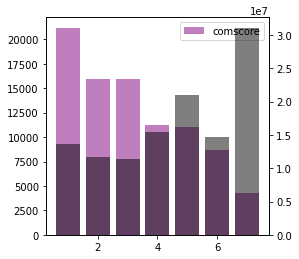

In [27]:

# Plot colors and things
c_acs = 'black'
c_comscore = 'purple'

fig,ax = plt.subplots(1,1,figsize=(4,4))
labels = list(range(1,8))
ax.bar(labels, demo_df['household_income'].value_counts().drop(8).values, 
       label='comscore',
       alpha=0.5, color=c_comscore)
ax2 = ax.twinx()
ax2.bar(labels, census_incomes.groupby('comscore_code').agg('sum')['count'], 
       label='ACS',
       alpha=0.5, color=c_acs)
_ = ax.legend()